## Autoencoder simples MLP utilizando o MNIST

![ae.png](attachment:254bc524-0b7d-4bba-886e-c58bd65357ae.png)

![image.png](attachment:38727fa8-6546-4724-b446-1697413452a6.png)

## imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image
import time

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

import torch
from torch import Tensor
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.nn import Sequential
from torch.nn import Linear
from torch.nn import ReLU
from torch.nn import Softmax, Tanh
from torch.nn import Module
from torch.nn import MSELoss, BCELoss
from torch.nn.init import kaiming_uniform_
from torch.nn.init import xavier_uniform_
from torch.optim import SGD, Adam 
from torch.optim.lr_scheduler import StepLR

from torchvision.transforms import Compose
from torchvision.transforms import ToTensor
from torchvision.utils import save_image, make_grid

#pip install torchinfo
from torchinfo import summary
from livelossplot import PlotLosses

In [ ]:
#Constants

#path para guardar o dataset
PATH = './'
PATH_TRAIN = './mnist_train.csv'
PATH_TEST = './mnist_test.csv'

BATCH_SIZE = 128

In [ ]:
#device management 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

device = get_default_device()
print(device)

cuda


## 1. Preparar os Dados.

In [ ]:
#buscar o dataset utilizando os CSVs e uma classe para o dataset

# definição classe para o dataset
class CSVDataset(Dataset):
    # ler o dataset
    def __init__(self, path_train, path_test):
        # ler o ficheiro csv para um dataframe
        df_train = pd.read_csv(path_train, header=0)
        df_test = pd.read_csv(path_test, header=0)
        # separar os inputs e os outputs
        self.x_train = df_train.values[:, 1:]
        xmax, xmin = self.x_train.max(), self.x_train.min()
        self.x_train  = (self.x_train - xmin)/(xmax - xmin)
        self.y_train = df_train.values[:, 0]
        self.x_test = df_test.values[:, 1:]
        xmax, xmin = self.x_test.max(), self.x_test.min()
        self.x_test  = (self.x_test - xmin)/(xmax - xmin)
        self.y_test = df_test.values[:, 0]
        # garantir que os inputs e labels sejam floats
        self.x_train = self.x_train.astype('float32')
        self.x_test = self.x_test.astype('float32')
        self.y_train = self.y_train.astype('long')
        self.y_test = self.y_test.astype('long')
        #print(self.x_train.shape)
        #print(self.y_train.shape)
        #print(self.x_train)
        #print(self.y_train)
        
    # numero de casos de treino no dataset
    def __len_train__(self):
        return len(self.x_train)
     # numero de casos de teste no dataset
    def __len_test__(self):
        return len(self.x_test)
    
    # retornar um caso
    def __getitem_train__(self, idx):
        return [self.x_train[idx], self.y_train[idx]]
     # retornar um caso
    def __getitem_test__(self, idx):
        return [self.x_test[idx], self.y_test[idx]]
    
    # retornar indeces para casos de treino de de teste em formato flat (vetor)
    def get_splits_flat(self):
        x_train  = torch.from_numpy(np.array(self.x_train))
        y_train  = torch.from_numpy(np.array(self.y_train))
        x_test  = torch.from_numpy(np.array(self.x_test))
        y_test  = torch.from_numpy(np.array(self.y_test))
        train = torch.utils.data.TensorDataset(x_train,y_train)
        test = torch.utils.data.TensorDataset(x_test,y_test)
        return train, test 
    
# preparar o dataset
def prepare_data_flat(path_train, path_test):
    # criar uma instancia do dataset
    dataset = CSVDataset(path_train, path_test)
    # calcular split
    train, test = dataset.get_splits_flat()
    # preparar data loaders
    train_dl = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True) #32 len(train)
    test_dl = DataLoader(test, batch_size=BATCH_SIZE, shuffle=True)
    train_dl_all = DataLoader(train, batch_size=len(train), shuffle=False)
    test_dl_all = DataLoader(test, batch_size=len(test), shuffle=False)
    return train_dl, test_dl, train_dl_all, test_dl_all

# preparar os dados
train_dl, test_dl,  train_dl_all, test_dl_all = prepare_data_flat(PATH_TRAIN, PATH_TEST)

## 1.1 Visualizar os Dados

In [ ]:
from IPython.display import display

def visualize_data(path):
    # criar uma instancia do dataset
    df = pd.read_csv(path, header=0)
    display(df)

def visualize_dataset(train_dl, test_dl):
    print(f"Quantidade de casos de Treino:{len(train_dl.dataset)}") 
    print(f"Quantidade de casos de Teste:{len(test_dl.dataset)}")
    x, y = next(iter(train_dl)) #fazer uma iteração nos loaders para ir buscar um batch de casos
    print(f"Shape tensor batch casos treino, input: {x.shape}, output: {y.shape}")
    x, y = next(iter(test_dl))  
    print(f"Shape tensor batch casos test, input: {x.shape}, output: {y.shape}")
    print(y)

visualize_data(PATH_TRAIN)
visualize_dataset(train_dl, test_dl)

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59997,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Quantidade de casos de Treino:60000
Quantidade de casos de Teste:10000
Shape tensor batch casos treino, input: torch.Size([128, 784]), output: torch.Size([128])
Shape tensor batch casos test, input: torch.Size([128, 784]), output: torch.Size([128])
tensor([9, 1, 4, 2, 9, 3, 4, 1, 5, 0, 7, 3, 7, 5, 7, 6, 4, 4, 5, 6, 9, 3, 2, 1,
        3, 7, 7, 5, 4, 0, 4, 8, 1, 0, 2, 6, 3, 0, 7, 0, 6, 1, 8, 3, 9, 5, 8, 5,
        3, 4, 7, 2, 4, 2, 8, 8, 3, 2, 2, 3, 4, 6, 9, 1, 6, 6, 7, 0, 9, 8, 6, 3,
        2, 0, 5, 6, 3, 6, 7, 5, 0, 2, 0, 3, 2, 9, 7, 2, 8, 0, 6, 5, 1, 2, 6, 8,
        9, 0, 7, 4, 5, 1, 8, 0, 4, 8, 9, 3, 8, 5, 9, 9, 3, 7, 8, 6, 7, 3, 2, 2,
        3, 4, 5, 6, 2, 1, 9, 9])


torch.Size([128, 784])
torch.Size([128, 1, 28, 28])


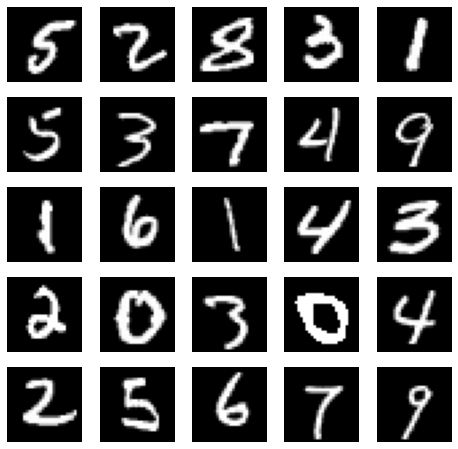

In [ ]:
#Visualização das imagens

def visualize_mnist_images_flat(dl):
    # get one batch of images
    i, (inputs, targets) = next(enumerate(dl))
    print(inputs.shape)
    inputs = inputs.reshape(len(inputs), 1, 28, 28)
    print(inputs.shape)
    # plot some images
    plt.figure(figsize=(8,8))
    for i in range(25):
        # define subplot

        plt.subplot(5, 5, i+1)
        plt.axis('off')
        plt.grid(b=None)
        # plot raw pixel data
        plt.imshow(inputs[i][0], cmap='gray')
    # show the figure
    plt.show()

visualize_mnist_images_flat(train_dl)

## 2. Definir o Modelo.

In [ ]:
# Definição classe para o Autoencoder

import models_mnist #modulo python com os modelos
    
# definir a rede neuronal
#model = models_mnist.autoencoderMLP(x_dim=28*28,  h_dim1= 512, h_dim2=256, ls_dim=2) #- 128
#model = models_mnist.autoencoderMLP(x_dim=28*28,  h_dim1= 256, h_dim2=128, ls_dim=2) #- 131
#model = models_mnist.autoencoderMLP(x_dim=28*28,  h_dim1= 784, h_dim2=512, ls_dim=2) #128
#model = models_mnist.autoencoderMLP_BN(x_dim=28*28,  h_dim1= 784, h_dim2=512, ls_dim=2) #overfitting dramatico 134/340
#model = models_mnist.autoencoderMLP_DROP(x_dim=28*28,  h_dim1= 784, h_dim2=512, ls_dim=2, drop=0.2) #131/133
#model = models_mnist.autoencoderMLP_P(x_dim=28*28, h_dim1=512, h_dim2=256, h_dim3=128, ls_dim=2) #120/123
model = models_mnist.AE_MLP_P(x_dim=28*28, h_dim1=256, h_dim2=128, h_dim3=64, ls_dim=2) #120/123

#visualizar a rede
print(summary(model, input_size=(BATCH_SIZE, 784), verbose=0)) #verbose=2 Show weight and bias layers in full detail
model.to(device)

Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [128, 256]                200,960
├─Linear: 1-2                            [128, 128]                32,896
├─Linear: 1-3                            [128, 64]                 8,256
├─Linear: 1-4                            [128, 2]                  130
├─Linear: 1-5                            [128, 64]                 192
├─Linear: 1-6                            [128, 128]                8,320
├─Linear: 1-7                            [128, 256]                33,024
├─Linear: 1-8                            [128, 784]                201,488
Total params: 485,266
Trainable params: 485,266
Non-trainable params: 0
Total mult-adds (M): 61.90
Input size (MB): 0.40
Forward/backward pass size (MB): 1.72
Params size (MB): 1.94
Estimated Total Size (MB): 4.06


AE_MLP_P(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=2, bias=True)
  (fc5): Linear(in_features=2, out_features=64, bias=True)
  (fc6): Linear(in_features=64, out_features=128, bias=True)
  (fc7): Linear(in_features=128, out_features=256, bias=True)
  (fc8): Linear(in_features=256, out_features=784, bias=True)
)

## 3. Treinar o Modelo.

In [ ]:
# treino do modelo
def train_model(h5_file,train_dl, test_dl, model, loss_function, optimizer, scheduler, epochs):
    liveloss = PlotLosses() 
    for epoch in range(epochs):
        logs = {} ##para visualizarmos o processo de treino
        model.train()
        running_loss  = 0.0
        for inputs, _ in train_dl:
            inputs = inputs.to(device)
            outputs,_ = model(inputs)
            loss = loss_function(outputs, inputs.view(-1, 784))
            optimizer.zero_grad() 
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        epoch_loss = running_loss / len(train_dl.dataset)
        logs['loss'] = epoch_loss #o 1000 é para ficar melhor no grafico
        scheduler.step() #callback a meio para atualizar lr
        epoch_lr = scheduler.get_last_lr()[0]
        logs['val_lr'] = epoch_lr 
        #Validation phase
        model.eval()
        running_loss  = 0.0
        for inputs, _ in test_dl: 
            inputs = inputs.to(device)
            outputs,_ = model(inputs)
            loss = loss_function(outputs, inputs)
            running_loss += loss.item()
        epoch_loss = running_loss / len(test_dl.dataset)
        logs['val_loss'] = epoch_loss #.item() 
        liveloss.update(logs) ##para visualizarmos o processo de treino
        liveloss.send() ##para visualizarmos o processo de treino
    torch.save(model,h5_file)

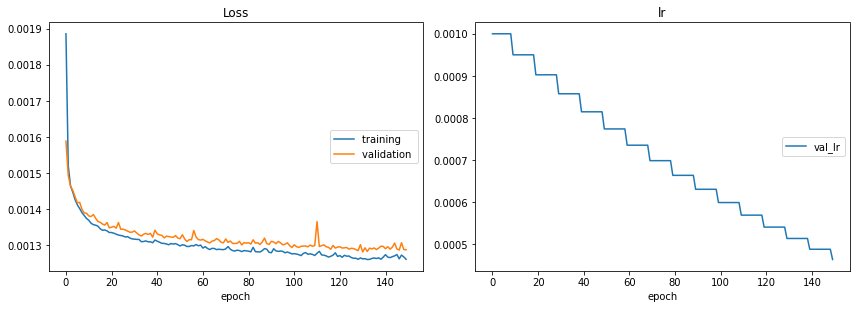

Loss
	training         	 (min:    0.001, max:    0.002, cur:    0.001)
	validation       	 (min:    0.001, max:    0.002, cur:    0.001)
lr
	val_lr           	 (min:    0.000, max:    0.001, cur:    0.000)
Tempo gasto: 1476.9739563018084 segundos


In [ ]:
# treinar o modelo

EPOCHS = 150
LEARNING_RATE = 1e-3

# definir o loss e a função de otimização
#loss_function = MSELoss()
loss_function = BCELoss()

#neste caso queremos a diferença relativamente aos valores originais
#optimizer = SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.5) #stochastic gradient descent
optimizer = Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
scheduler=StepLR(optimizer,step_size=10,gamma=0.95) 
starttime = time.perf_counter()
train_model('AE_MLP_P_MNIST.pth', train_dl, test_dl, model, loss_function, optimizer,scheduler, EPOCHS)
endtime = time.perf_counter()
print(f"Tempo gasto: {endtime - starttime} segundos")

## 4. Usar o Autoencoder.

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 1, 28, 28])


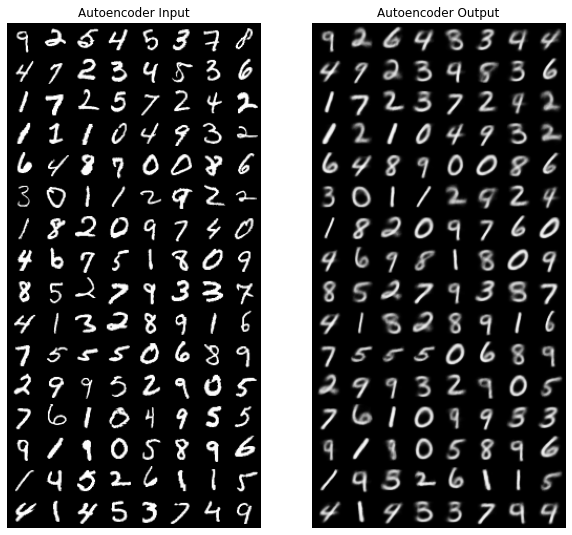

In [ ]:
def visualize(input_imgs, output_imgs):
    input_imgs=input_imgs.permute((1, 2, 0))
    output_imgs=output_imgs.permute((1, 2, 0))
    plt.subplots(1,2, figsize=(10, 10))
    plt.subplot(1,2,1)
    plt.axis('off')
    plt.grid(b=None)
    plt.title('Autoencoder Input')
    plt.imshow(input_imgs, cmap='gray')
    plt.subplot(1,2,2)
    plt.axis('off')
    plt.grid(b=None)
    plt.title('Autoencoder Output')
    plt.imshow(output_imgs, cmap='gray')
    plt.show()

def test_image_reconstruction(model, test_dl):
    for batch in test_dl:
        img, _ = batch
        img = img.to(device)
        img = img.view(img.size(0), -1)
        print(img.shape)
        outputs,_ = model(img)
        print(outputs.shape)
        outputs = outputs.view(outputs.size(0), 1, 28, 28).cpu().data
        print(outputs.shape)
        inputs = img.view(outputs.size(0), 1, 28, 28).cpu().data
        save_image(outputs, 'mnist_reconstruction_out.png')
        save_image(inputs, 'mnist_reconstruction_in.png')
        outputs = make_grid(outputs)
        inputs = make_grid(inputs)
        break 
    return inputs, outputs

inputs, outputs = test_image_reconstruction(model, test_dl)
visualize(inputs, outputs)

torch.Size([128, 784])
torch.float32
torch.Size([128, 784])
torch.Size([128, 1, 28, 28])


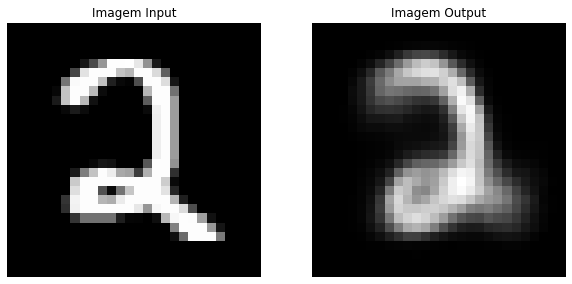

In [ ]:
# fazer uma previsão utilizando um caso

def make_prediction(model, img_list, idx): #img shape (784,1)

    print(img_list.shape)
    print(img_list.dtype) 
    img_list = img_list.to(device)
    prediction,_ = model(img_list)
    print(prediction.shape)
    prediction = prediction.view(prediction.size(0), 1, 28, 28).cpu().data
    print(prediction.shape)
    img = img_list[idx].reshape(1,28, 28).cpu() #shape (1,1,28,28)
    plt.subplots(1,2, figsize=(10, 10))
    plt.subplot(1,2,1)
    plt.axis('off')
    plt.grid(b=None)
    plt.title('Imagem Input')
    plt.imshow(img.permute((1, 2, 0)), cmap='gray')
    plt.subplot(1,2,2)
    plt.axis('off')
    plt.grid(b=None)
    plt.title('Imagem Output')
    plt.imshow(prediction[idx].permute((1, 2, 0)), cmap='gray')
    plt.show()
    
_, (inputs, targets) = next(enumerate(test_dl))
make_prediction(model,inputs, 10) #receives an image tensor with shape (784,1)